In [1]:
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import pickle5 as pickle
from glob import glob
from datetime import datetime
import re
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu


In [2]:
threshold={'hatespeech':0.9,'fearspeech':0.7,'normal':0.7}

In [3]:
dict_labels={'hatespeech':2,'fearspeech':1,'normal':0}
reverse_dict_labels={dict_labels[key]:key for key in dict_labels.keys()}

In [4]:
import re
import urllib.parse as urlparse
import emoji


GENERIC_TLDS = [
    'aero', 'asia', 'biz', 'com', 'coop', 'edu', 'gov', 'info', 'int', 'jobs', 
    'mil', 'mobi', 'museum', 'name', 'net', 'org', 'pro', 'tel', 'travel', 'cat'
    ]

def extract_emojis(line):
    return [c for c in line if c in emoji.UNICODE_EMOJI['en']]

def return_meta_info(element):
    dict_meta_info={}
    dict_meta_info['id']=element['id']
    dict_meta_info['reposts']=element['repost_count']
    dict_meta_info['replies']=element['reply_count']
    dict_meta_info['like_count']=element['like_count']
    return dict_meta_info


def get_domain(url):
    hostname = urlparse.urlparse(url.lower()).netloc
    if hostname == '':
        # Force the recognition as a full URL
        hostname = urlparse.urlparse('http://' + url).netloc

    # Remove the 'user:passw', 'www.' and ':port' parts
    hostname = hostname.split('@')[-1].split(':')[0].lstrip('www.').split('.')

    num_parts = len(hostname)
    if (num_parts < 3) or (len(hostname[-1]) > 2):
        return '.'.join(hostname[:-1])
    if len(hostname[-2]) > 2 and hostname[-2] not in GENERIC_TLDS:
        return '.'.join(hostname[:-1])
    if num_parts >= 3:
        return '.'.join(hostname[:-2])



def return_text_info(element):
    temp=element['post_body']
    all_emojis=extract_emojis(temp)
    #all_urls= re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', temp)
    all_urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', temp)
    all_hashtags=re.findall(r"#(\w+)", temp)
    
    dict_text_info={
        'num_hashtags':len(all_hashtags),
        'num_urls':len(all_urls),
        'num_emojis':len(all_emojis)
    }
    
    
    emoji_dict={}
    url_dict={}
    hashtag_dict={}
    
    for emoji in all_emojis:
        try:
            emoji_dict[emoji]+=1
        except KeyError:
            emoji_dict[emoji]=1
            
    for hashtag in all_hashtags:
        try:
            hashtag_dict[hashtag]+=1
        except KeyError:
            hashtag_dict[hashtag]=1
    for url in all_urls:
        try:
            url_dict[get_domain(url)]+=1
        except KeyError:
            url_dict[get_domain(url)]=1
        

    return dict_text_info,emoji_dict,url_dict,hashtag_dict

In [5]:
fear=0
hate=0
both=0
total=0
dict_per_date={}
dict_post_meta_info={}
dict_text_property={}
dict_emoji={'fearspeech':{},'hatespeech':{},'both':{},'total':{}}
dict_domain={'fearspeech':{},'hatespeech':{},'both':{},'total':{}}
dict_hashtag={'fearspeech':{},'hatespeech':{},'both':{},'total':{}}




files = sorted(glob('../../Gab_Data/new_features_old_gab/gab_fear_hate_features*.pickle'))
for file in tqdm_notebook(files,total=len(files)):
    with open(file, 'rb') as handle:
        Gab_keyword_match = pickle.load(handle)
        
    if('predicted_probab' not in Gab_keyword_match[1].keys()):
        continue
    
    for element in Gab_keyword_match:
        try:
            dt = datetime.fromisoformat(element['post_create_time'])
            key_new=str(dt.month)+'/'+str(dt.year)
        except KeyError:
            continue
            
        dict_meta_info_temp=return_meta_info(element)
        dict_text_property_temp,dict_emoji_temp,dict_domain_temp,dict_hashtag_temp=return_text_info(element)
        
        
        
        dict_meta_info_temp['label_probab']={}
        
        try:
            temp=dict_per_date[key_new]
        except:
            dict_per_date[key_new]={'fearspeech':0,'hatespeech':0,'both':0,'none':0,'total':0}

        labels=[]

        for i in range(len(element['predicted_probab'])):
            dict_meta_info_temp['label_probab'][reverse_dict_labels[i]]=element['predicted_probab'][i]
        
            if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                labels.append(reverse_dict_labels[i])
        
        dict_return_info=return_meta_info(element)
        
        
        if(('fearspeech' in labels) and ('hatespeech' in labels)):
            dict_per_date[key_new]['both']+=1
            dict_meta_info_temp['label']='both'
            both+=1
        elif('fearspeech' in labels):
            dict_per_date[key_new]['fearspeech']+=1
            dict_meta_info_temp['label']='fearspeech'
            fear+=1
        elif('hatespeech' in labels):
            dict_per_date[key_new]['hatespeech']+=1
            dict_meta_info_temp['label']='hatespeech'
            hate+=1
        else:
            dict_per_date[key_new]['none']+=1
            dict_meta_info_temp['label']='none'
        dict_per_date[key_new]['total']+=1
        
        dict_text_property_temp['label']=dict_meta_info_temp['label']
        
        for key in dict_emoji_temp:
            if(dict_meta_info_temp['label']!='none'):
                try:
                    dict_emoji[dict_meta_info_temp['label']][key]+=dict_emoji_temp[key]
                except KeyError:
                    dict_emoji[dict_meta_info_temp['label']][key]=dict_emoji_temp[key]

            
            try:
                dict_emoji['total'][key]+=dict_emoji_temp[key]
            except KeyError:
                dict_emoji['total'][key]=dict_emoji_temp[key]
        
        
        
        for key in dict_domain_temp:
            if(dict_meta_info_temp['label']!='none'):
                try:
                    dict_domain[dict_meta_info_temp['label']][key]+=dict_domain_temp[key]
                except KeyError:
                    dict_domain[dict_meta_info_temp['label']][key]=dict_domain_temp[key]

            
            try:
                dict_domain['total'][key]+=dict_domain_temp[key]
            except KeyError:
                dict_domain['total'][key]=dict_domain_temp[key]
        
        
        for key in dict_hashtag_temp:
            if(dict_meta_info_temp['label']!='none'):
                try:
                    dict_hashtag[dict_meta_info_temp['label']][key]+=dict_hashtag_temp[key]
                except KeyError:
                    dict_hashtag[dict_meta_info_temp['label']][key]=dict_hashtag_temp[key]

            
            try:
                dict_hashtag['total'][key]+=dict_hashtag_temp[key]
            except KeyError:
                dict_hashtag['total'][key]=dict_hashtag_temp[key]
        
        
        
        total+=1
        key_id=total
        dict_post_meta_info[key_id]=dict_meta_info_temp
        dict_text_property[key_id]=dict_text_property_temp

<ipython-input-5-df87712f04eb>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(files,total=len(files)):


  0%|          | 0/212 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
len(dict_domain['hatespeech'])

7493

In [8]:
len(dict_domain['both'])

14

In [9]:
len(dict_domain['total'])

131289

In [10]:
dict_domain_temp

{'rundblick-unna': 1}

In [7]:
dict_post_meta_info[key_id]

{'id': 16634209,
 'reposts': 0,
 'replies': 2,
 'like_count': 3,
 'label_probab': {'normal': 0.75161284,
  'fearspeech': 0.048907783,
  'hatespeech': 0.2500133},
 'label': 'none'}

In [ ]:
dict_fear={}
dict_hate={}
dict_normal={}

In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = []
for key in tqdm_notebook(dict_post_meta_info, total=len(dict_post_meta_info)):
    element=dict_post_meta_info[key]
    data.append(element['label_probab']['hatespeech'])
    
    
    if(element['label_probab']['fearspeech']>0.5):
        final=int(10*element['label_probab']['fearspeech'])
        try:
            dict_fear[final].append(element['id'])
        except KeyError:
            dict_fear[final]=[element['id']]
    if(element['label_probab']['hatespeech']>0.5):
        final=int(10*element['label_probab']['hatespeech'])
        try:
            dict_hate[final].append(element['id'])
        except KeyError:
            dict_hate[final]=[element['id']]
    if(element['label_probab']['normal']>0.5):
        final=int(10*element['label_probab']['normal'])
        try:
            dict_normal[final].append(element['id'])
        except KeyError:
            dict_normal[final]=[element['id']]

In [ ]:
sample_dict_hate={}

for key in dict_hate:
    sample_dict_hate[key]=random.sample(dict_hate[key],20)
    

sample_dict_fear={}

for key in dict_fear:
    sample_dict_fear[key]=random.sample(dict_fear[key],20)
    
   
    
    


In [ ]:
import pickle

#my_dict = { 'Ali': 9, 'Sid': 1, 'Luna': 7, 'Sim': 12, 'Pooja': 4, 'Jen': 2}
with open('../Results/fearspeech_thresholding.json', 'wb') as fp:
    pickle.dump(sample_dict_fear, fp)
    
with open('../Results/hatespeech_thresholding.json', 'wb') as fp:
    pickle.dump(sample_dict_hate, fp)



In [ ]:
# fixed bin size

plt.hist(data,color='orange')
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [ ]:
element

In [11]:
print(fear+both,
hate+both,
both,
total)

426455 709358 200 21200212


In [11]:


with open('../Results/dict_per_date.json', 'w') as fp:
    json.dump(dict_per_date, fp)


In [12]:
(fear+hate+both)/total

0.05356611528224341

In [13]:
dict_per_date_normalised={}
for key in dict_per_date:
    dict_per_date_normalised[key]={'fearspeech':0,'hatespeech':0,'both':0,'none':0,'total':0}
    for key1 in dict_per_date_normalised[key].keys():
        dict_per_date_normalised[key][key1]=dict_per_date[key][key1]/(dict_per_date[key]['total'])
        
#         if(dict_per_date_normalised[key][key1]>0.2):
#             dict_per_date_normalised[key][key1]=0.2
        
        

In [14]:
df=pd.DataFrame(dict_per_date_normalised).transpose()
df.index=pd.to_datetime(df.index)

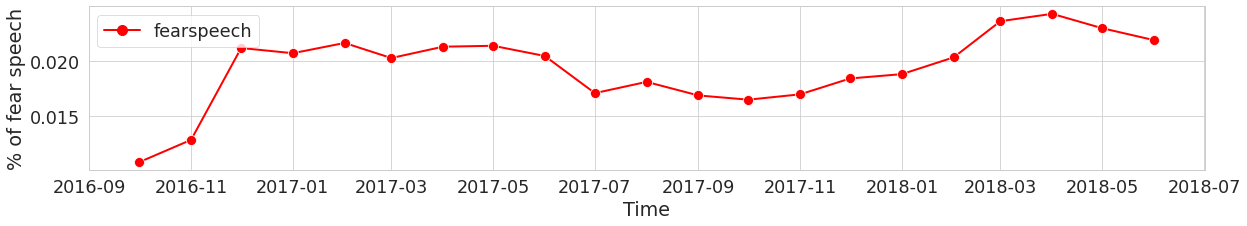

In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 3)

sns.set(context='paper',style='whitegrid',font_scale=2.0, rc={"lines.linewidth": 2.0,"lines.markersize": 10})
sns.lineplot(data = df[["fearspeech"]],palette=['red'],markers=['o'])
plt.xlabel("Time")
plt.ylabel("% of fear speech")
path='../Results/fearspeech_temporal.pdf'
plt.savefig(path,bbox_inches='tight',dpi=400)
    

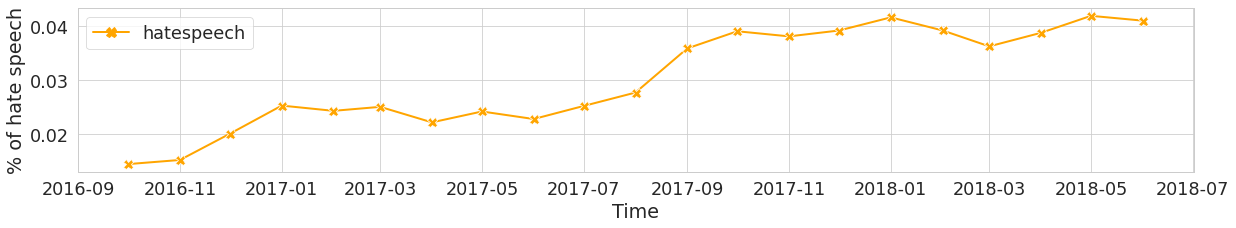

In [68]:
plt.figure()
sns.lineplot(data = df[["hatespeech"]],palette=['orange'],markers=['X'])
plt.xlabel("Time")
plt.ylabel("% of hate speech")
path='../Results/hatespeech_temporal.pdf'
plt.savefig(path,bbox_inches='tight',dpi=400)

# plt.figure()
# sns.lineplot(data = df[["both"]],palette=['brown'])

In [29]:
def plot_count(dict_new,title_text,select_column):
    x_values=['fearspeech','hatespeech','total']
    y_values=[]
    for x_val in x_values:
        if(x_val=='total'):
            count=0
            for key in tqdm_notebook(dict_new,total=len(dict_new)):
                if(dict_new[key][select_column]!=0):
                    count+=1
            y_values.append(100*count/len(dict_new))
        else:
            count=0
            count_total=0
            for key in tqdm_notebook(dict_new,total=len(dict_new)):
                if((dict_new[key]['label']==x_val)):
                    if(dict_new[key][select_column]!=0):
                        count+=1
                    count_total+=1
                   
            y_values.append(100*count/count_total)
    c= ['red', 'orange', 'green']
    fig = plt.figure(figsize = (4,4))
     
    # creating the bar plot
    plt.bar(x_values,y_values, color =c,
        width = 0.4)

   

    #plt.legend(x_values)
    plt.xlabel("Speech type")
    plt.ylabel("% of post that are "+ select_column)
    plt.title(title_text)
    path='../Results/'+'_'.join(title_text.split())+'.pdf'
    plt.savefig(path,bbox_inches='tight',dpi=400)
#     plt.show()

    
def plot_mean(dict_new,title_text,select_column):
    x_values=['fearspeech','hatespeech','total']
    y_values=[]
    y_err=[]
    
    y_values_list=[]
    
    for x_val in x_values:
        if(x_val=='total'):
            count=[]
            for key in tqdm_notebook(dict_new,total=len(dict_new)):
                if(dict_new[key][select_column]!=0):
                    count.append(dict_new[key][select_column])
            y_values.append(np.mean(count))
            y_err.append(np.std(count))
            y_values_list.append(count)
        else:
            count=[]
            for key in tqdm_notebook(dict_new,total=len(dict_new)):
                if((dict_new[key]['label']==x_val)):
                    if(dict_new[key][select_column]!=0):
                        count.append(dict_new[key][select_column])
                   
            y_values.append(np.mean(count))
            y_err.append(np.std(count))
            y_values_list.append(count)
    c= ['red', 'orange', 'green']
    fig = plt.figure(figsize = (4,4))
    
    
    
    stat, p = mannwhitneyu(y_values_list[0],y_values_list[1],alternative='greater')
    print("p-value between fear speech mean and hate speech mean",p)
    
    stat, p = mannwhitneyu(y_values_list[1],y_values_list[2],alternative='greater')
    print("p-value between hate speech mean and normal mean",p)
    
    
    stat, p = mannwhitneyu(y_values_list[0],y_values_list[2],alternative='greater')
    print("p-value between fear speech mean and normal mean",p)
    
    # creating the bar plot
    x_values_plot=['F','H','T']
    
    plt.bar(x_values_plot,y_values,color =c,capsize=1,align='center',width = 0.5)
    #plt.errorbar(x_values,y_values,y_err)
   

    #plt.legend(x_values)
    #plt.xlabel("Speech type")
    plt.ylabel("#" + select_column + "/post")
    #plt.title(title_text)
    
    
    path='../Results/'+'_'.join(title_text.split())+'.pdf'
    plt.savefig(path,bbox_inches='tight',dpi=400)
    #plt.show()


### Reposts

<ipython-input-17-048a8908f62d>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-17-048a8908f62d>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

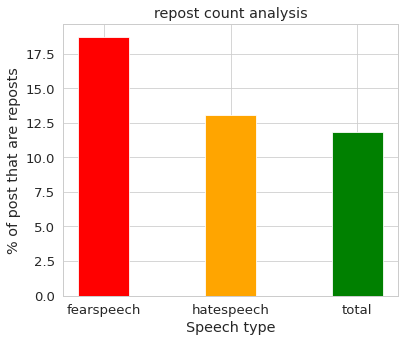

In [18]:
sns.set(context='paper',style='whitegrid',font_scale=1.5)

plot_count(dict_post_meta_info,'repost count analysis','reposts')


<ipython-input-29-fbc3101f165f>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

p-value between fear speech mean and hate speech mean 0.0
p-value between hate speech mean and normal mean 1.0
p-value between fear speech mean and normal mean 0.0


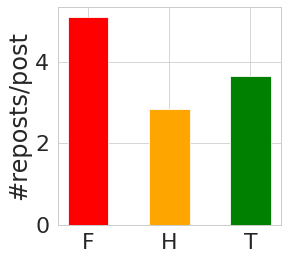

In [30]:
sns.set(context='paper',style='whitegrid',font_scale=2.5)

plot_mean(dict_post_meta_info,'repost mean analysis','reposts')

### Replies

<ipython-input-70-2191c9c053b4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-70-2191c9c053b4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

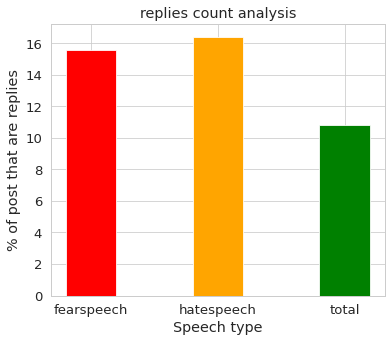

In [73]:
plot_count(dict_post_meta_info,'replies count analysis','replies')


<ipython-input-29-fbc3101f165f>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

p-value between fear speech mean and hate speech mean 2.856388765838556e-268
p-value between hate speech mean and normal mean 0.001537385590995161
p-value between fear speech mean and normal mean 0.0


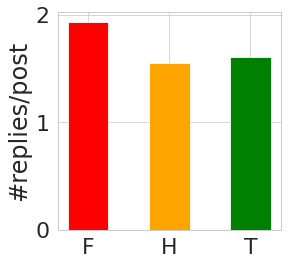

In [31]:
plot_mean(dict_post_meta_info,'replies mean analysis','replies')


### Favourites

<ipython-input-29-fbc3101f165f>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

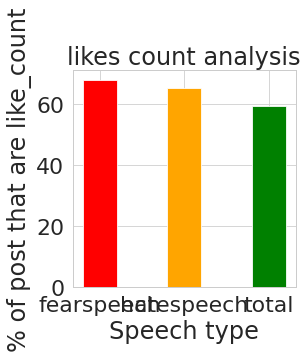

In [32]:
plot_count(dict_post_meta_info,'likes count analysis','like_count')


<ipython-input-29-fbc3101f165f>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

p-value between fear speech mean and hate speech mean 0.0
p-value between hate speech mean and normal mean 2.3488971307475242e-163
p-value between fear speech mean and normal mean 0.0


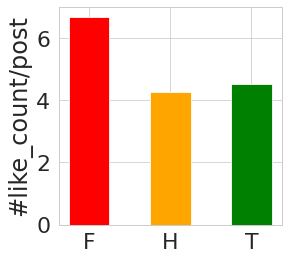

In [33]:
plot_mean(dict_post_meta_info,'like mean analysis','like_count')


## Text analytics

### Emojis

<ipython-input-70-2191c9c053b4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-70-2191c9c053b4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

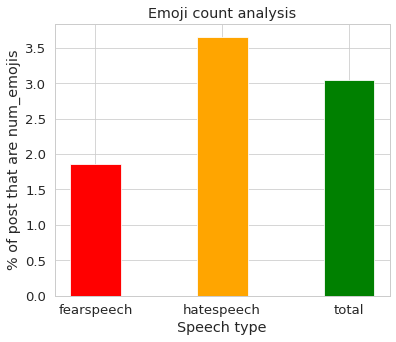

In [77]:
plot_count(dict_text_property,'Emoji count analysis','num_emojis')


<ipython-input-29-fbc3101f165f>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

p-value between fear speech mean and hate speech mean 1.0
p-value between hate speech mean and normal mean 2.6644057696597405e-171
p-value between fear speech mean and normal mean 1.4417579841715884e-05


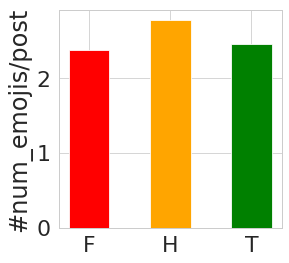

In [35]:
plot_mean(dict_text_property,'Emoji mean analysis','num_emojis')


### Hashtags

<ipython-input-70-2191c9c053b4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-70-2191c9c053b4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

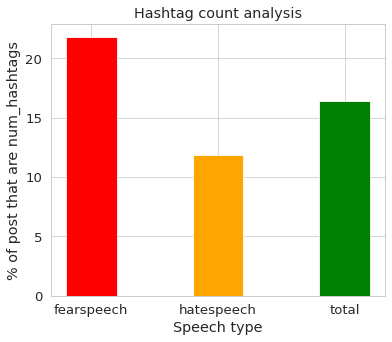

In [79]:
plot_count(dict_text_property,'Hashtag count analysis','num_hashtags')


<ipython-input-29-fbc3101f165f>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

p-value between fear speech mean and hate speech mean 0.0
p-value between hate speech mean and normal mean 1.0
p-value between fear speech mean and normal mean 0.0


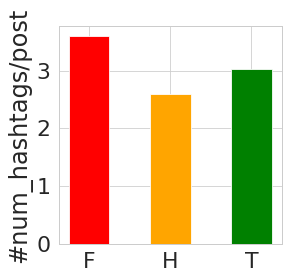

In [36]:
plot_mean(dict_text_property,'Hashtag mean analysis','num_hashtags')


### Urls

<ipython-input-70-2191c9c053b4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-70-2191c9c053b4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

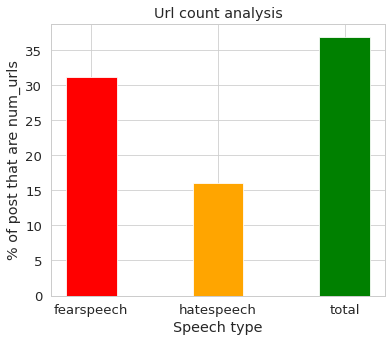

In [81]:

plot_count(dict_text_property,'Url count analysis','num_urls')


<ipython-input-29-fbc3101f165f>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

  0%|          | 0/21200212 [00:00<?, ?it/s]

<ipython-input-29-fbc3101f165f>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(dict_new,total=len(dict_new)):


  0%|          | 0/21200212 [00:00<?, ?it/s]

p-value between fear speech mean and hate speech mean 0.0
p-value between hate speech mean and normal mean 1.0
p-value between fear speech mean and normal mean 5.361354022994717e-247


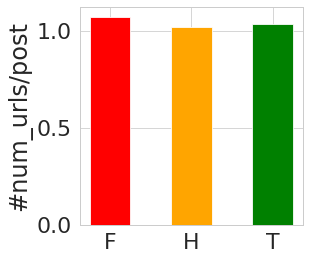

In [37]:
plot_mean(dict_text_property,'Url mean analysis','num_urls')


In [83]:
import gzip
with gzip.open('../../../../Gab_Data_old/Reposts.pkl.gz','rb') as fp:
    dict_repost = pickle.load(fp)

In [25]:
list(dict_repost.keys())[0]

24609334

In [32]:
for key in dict_repost.keys():
    temp=dict_repost[key]
    
    for ele in temp:
        if('2017-01' in ele['reposting_time']):
            print(ele['reposting_time'])


In [ ]:
def return_text_info(element):
    temp=element['post_body']
    all_emojis=extract_emojis(temp)
    #all_urls= re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', temp)
    all_urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', temp)
    all_hashtags=re.findall(r"#(\w+)", temp)
    
    dict_text_info=
    {
        'num_hashtags':len(all_hashtags),
        'num_urls':len(all_urls),
        'num_emojis':len(all_emojis)
    }
    
    
    emoji_dict={}
    url_dict={}
    hashtag_dict={}
    
    for emoji in all_emojis:
        try:
            emoji_dict[emoji]+=1
        except KeyError:
            emoji_dict[emoji]=1
            
    for hashtag in all_hashtags:
        try:
            hashtag_dict[hashtag]+=1
        except KeyError:
            hashtag_dict[hashtag]=1
    for url in all_urls:
        try:
            url_dict[get_domain(url)]+=1
        except KeyError:
            url_dict[get_domain(url)]=1
        

    return dict_text_info,emoji_dict,url_dict,hashtag_dict